In [1]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import numpy as np
from tqdm import tqdm

In [2]:
# Input Dataset 

DM = pd.read_csv("C:\\Data Raihan\Penelitian Threshold\\Dataset\\APIsecurityAccessbehavoranomalydataset\\supervised_dataset.csv") #DM--> Dataset Malware

In [3]:
DM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int64(2), object(4)

In [4]:
#Feature Selection
features = DM.drop(['Unnamed: 0','_id','source', 'ip_type', 'classification'],axis=1).columns.tolist()
# Target variable
y = DM['classification'].values

In [5]:
# Memilih 5% data secara acak dari setiap fitur/column
sampled_data = DM.groupby('classification').apply(lambda x: x.sample(frac=1)).reset_index(drop=True)

In [6]:
for i, column_name in enumerate(features):
    print(f"{i+1:3} {column_name:40} {sampled_data[column_name].count():<15} {sampled_data[column_name].dtype}")

  1 inter_api_access_duration(sec)           1695            float64
  2 api_access_uniqueness                    1695            float64
  3 sequence_length(count)                   1699            float64
  4 vsession_duration(min)                   1699            int64
  5 num_sessions                             1699            float64
  6 num_users                                1699            float64
  7 num_unique_apis                          1699            float64


In [7]:
# Mencoba mencari threshold terbaik pada fitur yang dipilih
hasil_threshold = []

def Thresholding(threshold, feature):
    # Melakukan thresholding
    BenignDataThreshold = sampled_data[sampled_data[feature] > int(threshold)]
    MalwareDataThreshold = sampled_data[sampled_data[feature] <= int(threshold)]

    # menentukan TP, TN, FP, FN
    from sklearn.metrics import confusion_matrix

    # Untuk BenignDataThreshold
    y_true_benign = ["normal"] * len(BenignDataThreshold)
    y_pred_benign = BenignDataThreshold["classification"]

    # Untuk MalwareDataThreshold
    y_true_malware = ["outlier"] * len(MalwareDataThreshold)
    y_pred_malware = MalwareDataThreshold["classification"]

    # Menyatukan true labels dan predicted labels
    y_true = y_true_benign + y_true_malware
    y_pred = y_pred_benign.tolist() + y_pred_malware.tolist()

    # Menghitung confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Menghitung Precision, Recall, F1-score, dan Accuracy
    PrecisionThreshold = tp/(tp+fp) if (tp+fp) != 0 else 0
    RecallThreshold = tp/(tp+fn) if (tp+fn) != 0 else 0
    F1ScoreThreshold = 2 * ((PrecisionThreshold*RecallThreshold)/(PrecisionThreshold+RecallThreshold)) if (PrecisionThreshold+RecallThreshold) != 0 else 0
    AccuracyThreshold = (tp+tn)/(tp+fp+tn+fn) if (tp+fp+tn+fn) != 0 else 0

    matrix = [[feature, threshold], [PrecisionThreshold], [RecallThreshold], [F1ScoreThreshold], [AccuracyThreshold]]
    hasil_threshold.append(matrix)

for feature in tqdm(features, desc='Progress'):
    Max = sampled_data[feature].max()
    Min = sampled_data[feature].min()

    for x in range(int(Min), int(Max + 1)):
        Thresholding(x, feature)

print(hasil_threshold)

Progress: 100%|██████████████████████████████████████████████████████████████████████| 7/7 [1:59:40<00:00, 1025.79s/it]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
winner = [['', 0], [0], [0], [0], [0]]  # Format: [[feature, threshold], [precision], [recall], [f1-score], [accuracy]]

for result in hasil_threshold:
    if result[4][0] > winner[4][0]:
        winner = result

print(f"Dengan fitur {winner[0][0]} dan threshold {winner[0][1]}, menghasilkan akurasi {winner[4][0]} yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.")


Dengan fitur num_users dan threshold 1, menghasilkan akurasi 1.0 yang menjadikan angka threshold tersebut adalah threshold terbaik yang dapat digunakan.


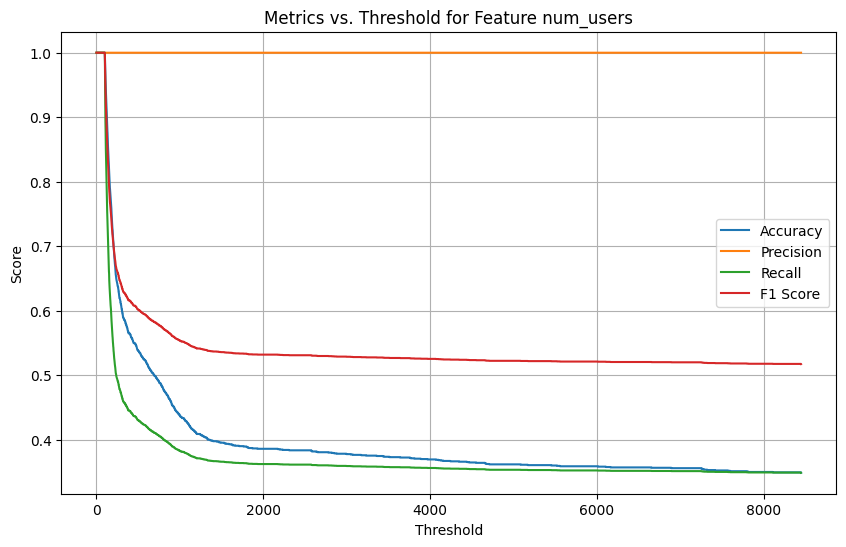

In [9]:
# Mendapatkan fitur pemenang dan thresholdnya
winner_feature, winner_threshold = winner[0]

# Memfilter hasil threshold untuk fitur pemenang
winner_results = [result for result in hasil_threshold if result[0][0] == winner_feature]

# Pisahkan hasil menjadi list berdasarkan feature dan kolom
thresholds, precision, recall, f1_score, accuracy = [], [], [], [], []
for result in winner_results:
    thresholds.append(result[0][1])
    precision.append(result[1][0])
    recall.append(result[2][0])
    f1_score.append(result[3][0])
    accuracy.append(result[4][0])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.plot(thresholds, f1_score, label='F1 Score')

plt.title(f'Metrics vs. Threshold for Feature {winner_feature}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()